<h1> CIFAR-10 DATASET </h1>

* 60k images dimension(32×32)
* 10 classes

In [ ]:
import pickle
import glob
import fnmatch
import os
import np_utils
import cv2
from keras.utils import np_utils
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [7]:
def flat3d(array):  # input is 3072 lenghth of numpy array
    arr = np.array([])
    r = array[0:1024].reshape(1024,1)
    g = array[1024:2048].reshape(1024,1)
    b = array[2048:3072].reshape(1024,1)
    arr = np.concatenate((r,g,b),axis=1)
    return arr.reshape(32,32,3)

In [8]:
appended_train_data = []
appended_train_labels = []
appended_test_data = []

#Create Training set
for file in os.listdir('.'):
    if 'data_batch' in file:
        batch = unpickle(file)
        batch_data = batch[b'data']
        
        for array in batch_data:
            img = flat3d(array)
            appended_train_data.append(img)

        appended_train_labels.append(batch[b'labels'])

train_data = np.asarray(appended_train_data)
train_labels = np.asarray(appended_train_labels).flatten()

#Creating Test set
test_batch = unpickle('test_batch')
test_batch_data = test_batch[b'data']
test_labels = np.asarray(test_batch[b'labels'])

for array in test_batch_data:
    img = flat3d(array)
    appended_test_data.append(img)

test_data = np.asarray(appended_test_data)

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [9]:
#Load the META data
label_names = unpickle('batches.meta')[b'label_names']
num_classes = len(label_names)
print(label_names)

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


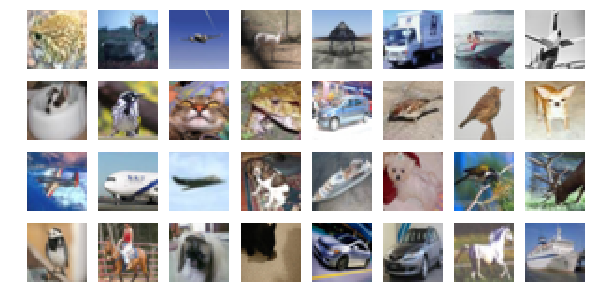

In [10]:
#Visualize random images out of the train data
nrows = 4
ncols = 8

fig, axes =plt.subplots(nrows, ncols, figsize=(10,5))

for i, ax in enumerate(axes.flat): 
    rand = random.randint(1,train_data.shape[0])
    plt.subplot(nrows, ncols, i+1)
    plt.axis('off')
    ax = plt.imshow(train_data[rand])

In [11]:
# Standardize
mean_train = np.mean(train_data)
std_train = np.std(train_data)

train_data_std = (train_data-mean_train)/(std_train)
X_test = (test_data-mean_train)/(std_train)

labels_cat = np_utils.to_categorical(train_labels, num_classes)
y_test = np_utils.to_categorical(test_labels, num_classes)

In [12]:
#Split in training and validation set

X_train, X_val, y_train, y_val = train_test_split(train_data_std, labels_cat, test_size=0.1, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(45000, 32, 32, 3)
(5000, 32, 32, 3)
(10000, 32, 32, 3)
(45000, 10)
(5000, 10)
(10000, 10)


In [13]:
#Hyperparameter
batch_size = 100
epochs=3
lr = 0.001 

In [14]:
#Placeholder
x = tf.placeholder("float", [None, 32,32,3])
y = tf.placeholder("float", [None, num_classes])

In [15]:
#Variables
hidden_layer_1 = {'wc1': tf.get_variable('W0', shape=(3,3,3,32), initializer=tf.contrib.layers.xavier_initializer()),
                  'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer())}

hidden_layer_2 = {'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()),
                  'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer())}

hidden_layer_3 = {'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()),
                 'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer())}

fully_connected = {'wd1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.contrib.layers.xavier_initializer()),
                  'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer())}

output_layer = {'wo': tf.get_variable('W6', shape=(128,num_classes), initializer=tf.contrib.layers.xavier_initializer()),
               'bo': tf.get_variable('B4', shape=(10), initializer=tf.contrib.layers.xavier_initializer())}

In [ ]:
#To reset the graph
tf.reset_default_graph() 

In [16]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) 

In [17]:
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

In [18]:
def conv_net(x):  

    conv1 = conv2d(x, hidden_layer_1['wc1'], hidden_layer_1['bc1'])
    conv1 = maxpool2d(conv1, k=2)

    conv2 = conv2d(conv1, hidden_layer_2['wc2'], hidden_layer_2['bc2'])
    conv2 = maxpool2d(conv2, k=2)

    conv3 = conv2d(conv2, hidden_layer_3['wc3'], hidden_layer_3['bc3'])
    conv3 = maxpool2d(conv3, k=2)

    fc1 = tf.reshape(conv3, [-1, fully_connected['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, fully_connected['wd1']), fully_connected['bd1'])
    fc1 = tf.nn.relu(fc1)
    
    out = tf.add(tf.matmul(fc1, output_layer['wo']), output_layer['bo'])
    
    return out

In [19]:
pred = conv_net(x)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

optimizer = tf.train.AdamOptimizer(lr).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [20]:
#Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

#calculate accuracy across all the given images and average them out. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [21]:
# Initializing the variables
init = tf.global_variables_initializer()

In [ ]:
#Create a Saver for saving and restoring
saver = tf.train.Saver()

In [22]:
#short
X_train_short = X_train[0:2000]
X_val_short = X_val[0:200] 
y_train_short = y_train[0:2000] 
y_val_short = y_val[0:200] 

In [ ]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for epoch in range(epochs):
        for batch in range(len(X_train_short)//batch_size):
            batch_x = X_train_short[batch*batch_size:min((batch+1)*batch_size,len(X_train_short))]
            batch_y = y_train_short[batch*batch_size:min((batch+1)*batch_size,len(y_train_short))]    
            # Run optimization
                # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
            
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y})
        print("Epoch " + str(epoch) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        print("Optimization Finished!")

        # Calculate accuracy for all 5000 validation images
        val_acc, valid_loss = sess.run([accuracy,cost], feed_dict={x: X_val_short,y : y_val_short})
        train_loss.append(loss)
        val_loss.append(valid_loss)
        train_accuracy.append(acc)
        val_accuracy.append(val_acc)
        print("Validation Accuracy:","{:.5f}".format(val_acc))
    summary_writer.close()
    
    #save the model
    save_path = 'Checkpoint/model.ckpt'
    saver.save(sess, save_path)
    print("Model saved in path: %s" % save_path)

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)

In [ ]:
plt.plot(train_accuracy)
plt.plot(val_accuracy)

In [27]:
def test_neural_network(X_test, y_test):
    
    test_acc =  []
    test_correct_pred = []
    test_labels = []
    
    pred = conv_net(x)
    
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        try:
            saver.restore(sess,"Checkpoint/model.ckpt")
            print('Restored model succesfully')
        except Exception as e:
            print(str(e))
        epoch_loss = 0
        
        #Returns the predicted label
        label = tf.argmax(pred, dimension=1)
        
        #Bool return if predicted label is equal to true label
        correct = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        
        #Process the test data in batches of size batch_size
        for batch in range(len(X_test)//batch_size):
            batch_x = X_test[batch*batch_size:min((batch+1)*batch_size,len(X_test))]
            batch_y = y_test[batch*batch_size:min((batch+1)*batch_size,len(y_test))]    
            
            labels = label.eval({x:batch_x, y:batch_y})
            correct_pred = correct.eval({x:batch_x, y:batch_y})
            acc = accuracy.eval({x:batch_x, y:batch_y})
            
            #Append the resuts of each batch to a list
            test_labels.append(labels)
            test_correct_pred.append(correct_pred)
            test_acc.append(acc)
        
        flat_labels = np.asarray(test_labels).flatten()
        flat_pred = np.asarray(test_correct_pred).flatten()
        acc = np.mean(np.asarray(test_acc).flatten())
        
        return flat_labels, flat_pred, acc

In [28]:
labels, correct_pred, acc= test_neural_network(X_test, y_test)

INFO:tensorflow:Restoring parameters from Checkpoint/model.ckpt
Restored model succesfully


In [29]:
print(acc)

0.38219994
